In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [3]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=0.1):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

Reseting datasets values with new specs


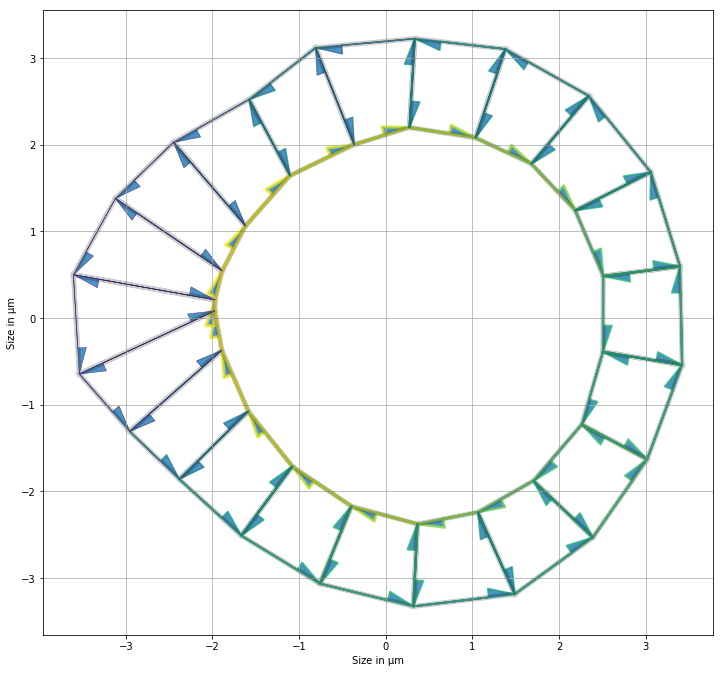

In [4]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7059015c0>)

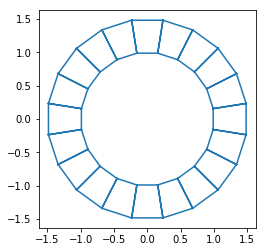

In [5]:
sym_org = generate_ring(nf, r_in, r_out)
geom.update_all(sym_org)
quick_edge_draw(sym_org)

In [6]:
#selectionner les coordonnées des vertex apicaux
api_vertex = organo.vert_df.loc[organo.apical_verts, ('x', 'y')]
#centre des cellules
cell_centers = organo.face_df.loc[:, ('x', 'y')]

In [7]:
api_vertex.head()

,x,y
vert,,
0,2.505490,-0.389034
1,2.260841,-1.227482
2,1.704032,-1.876593
3,1.063769,-2.239495
4,0.366279,-2.375904


In [8]:
cell_centers.head()

,x,y
face,,
0,2.800145,-0.947523
1,2.342210,-1.816765
2,1.660884,-2.458632
3,0.808607,-2.782078
4,-0.118299,-2.734780


## Matrice et constante de l'inférence de forces

In [24]:
organo.edge_df.head()

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,fy,segment,prev,sub_area,ux,uy,uz,line_tension,is_active,opposite
edge,,,,,,,,,,,,,,,,,,,,,
0,1,0.383687,0.873412,0,0,-0.244649,-0.838449,2.505490,-0.389034,2.260841,...,-0.947523,apical,40,0.191844,-0.280107,-0.959969,0.0,0.150,1,-1
1,2,0.380936,0.855208,1,1,-0.556809,-0.649110,2.260841,-1.227482,1.704032,...,-1.816765,apical,41,0.190468,-0.651080,-0.759009,0.0,0.165,1,-1
2,3,0.357000,0.735958,2,2,-0.640262,-0.362902,1.704032,-1.876593,1.063769,...,-2.458632,apical,42,0.178500,-0.869971,-0.493102,0.0,0.180,1,-1
3,4,0.343640,0.710704,3,3,-0.697491,-0.136408,1.063769,-2.239495,0.366279,...,-2.782078,apical,43,0.171820,-0.981408,-0.191934,0.0,0.195,1,-1
4,5,0.372339,0.788677,4,4,-0.761782,0.204205,0.366279,-2.375904,-0.395504,...,-2.734780,apical,44,0.186169,-0.965899,0.258920,0.0,0.210,1,-1


In [36]:
import time
def mean_nz(edges):
    return edges['nz'].mean()


organo.edge_df.groupby('face').apply(mean_nz)

face
0     0.446705
1     0.435653
2     0.449570
3     0.455920
4     0.448305
5     0.457066
6     0.464841
7     0.480750
8     0.504640
9     0.512420
10    0.515002
11    0.512517
12    0.494531
13    0.485186
14    0.491442
15    0.475430
16    0.469422
17    0.459437
18    0.451422
19    0.452510
dtype: float64

In [9]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

Calcul des paramètres dans l'organoïde régulier

In [10]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

Calcul du "coefficient de polarisation", avec le 

In [11]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    parrallel_edges = (organo.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo.edge_df.face == cell]).values
    apical_middle = organo.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.7804046 , 1.80896929, 1.97237282, 1.95819428, 1.91354156,
       1.9663041 , 2.13011039, 2.5651894 , 3.14946586, 3.26946007,
       3.11867021, 2.77275355, 2.28573431, 2.22316687, 2.20358018,
       2.11542926, 2.09600265, 1.99059355, 1.86836   , 1.82366071])

In [12]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    api_vertex = organo.edge_df.loc[organo.apical_edges,
                                    ('srce', 'trgt')][organo.edge_df.face == cell]
    coord_api_vertex = organo.vert_df.loc[np.squeeze(api_vertex.values),
                                          ('x', 'y')].values
    coord_cell_center = np.squeeze(organo.face_df.loc[[cell], ('x', 'y')].values)
    #((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2)))
    pos_param = np.dot(coord_cell_center - coord_api_vertex[0],
                       coord_cell_center - coord_api_vertex[1])
    comp = np.array((coord_api_vertex[1, 0] - coord_api_vertex[0, 0],
                     coord_api_vertex[1, 1] - coord_api_vertex[0, 1]))
    proj = coord_api_vertex[0] + pos_param * comp
    #api_vert = organo.vert_df.loc[organo.apical_verts[[cell, (cell+1)%organo.Nf]],
    #                              ('x', 'y')].values
    polar_coefs[cell] = np.linalg.norm(proj - coord_cell_center)
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([0.6298519 , 0.58552087, 0.54554701, 0.5578145 , 0.57129197,
       0.57944321, 0.56423776, 0.59851501, 0.78701856, 0.81035332,
       0.76745019, 0.70391654, 0.6724686 , 0.63208301, 0.60714558,
       0.60834998, 0.59372321, 0.59204298, 0.62304487, 0.62635186])

[0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117]
-2.089057215490175
[0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117, 0.25620594142732117]
(100, 81) (100,)
[0.07356781 0.07267758 0.08596555 0.08772626 0.08438682 0.08892019
 0.09638706 0.11186477 0.13021605 0.14663782 0.14114834

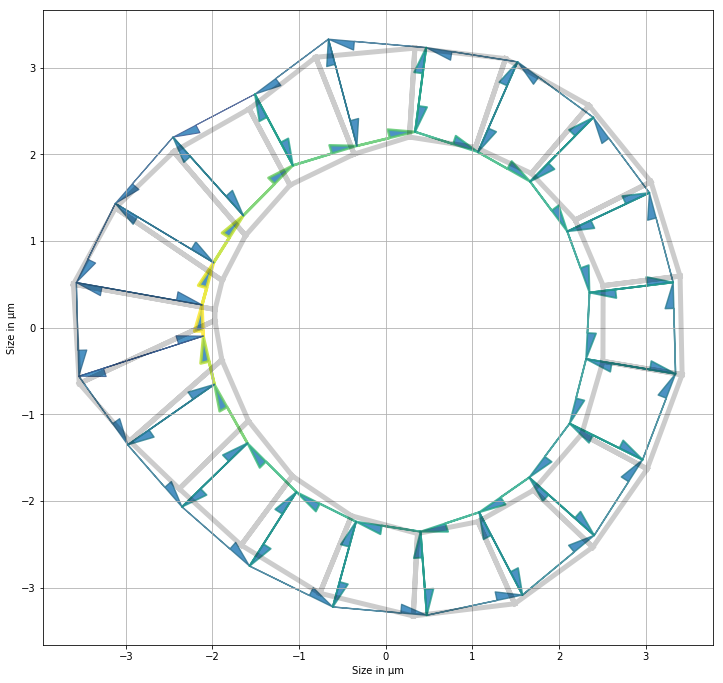

In [13]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
matrix = matrix[:-1]
constant = constant[:-1]
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
#avg_cste = [2.44/(3*organo.Nf)*4]*organo.Nf
print(avg_cste)
#avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
#area_ela_line = np.concatenate((np.zeros(organo.Nf*3),
#                                np.ones(organo.Nf),
#                                [0]))
#matrix = np.vstack((matrix, area_ela_line))
#constant = np.concatenate((constant, [-params_in_sym_mesh[0]*organo.Nf]))
print(params_in_sym_mesh[0]*organo.Nf)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i))
    index_suiv = np.squeeze(np.argwhere(organo.edge_df.face.values == (i+1)%organo.Nf))
    index[-1] = index_suiv[-2]
    #index[-1] = 40
    #print(index)
    i_cell_line[index] = [polar_coefs[i], 1, 1, 1]
    #print(i_cell_line)
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
print(matrix.shape, constant.shape)
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print(mat_eq_cst[organo.apical_edges])
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)

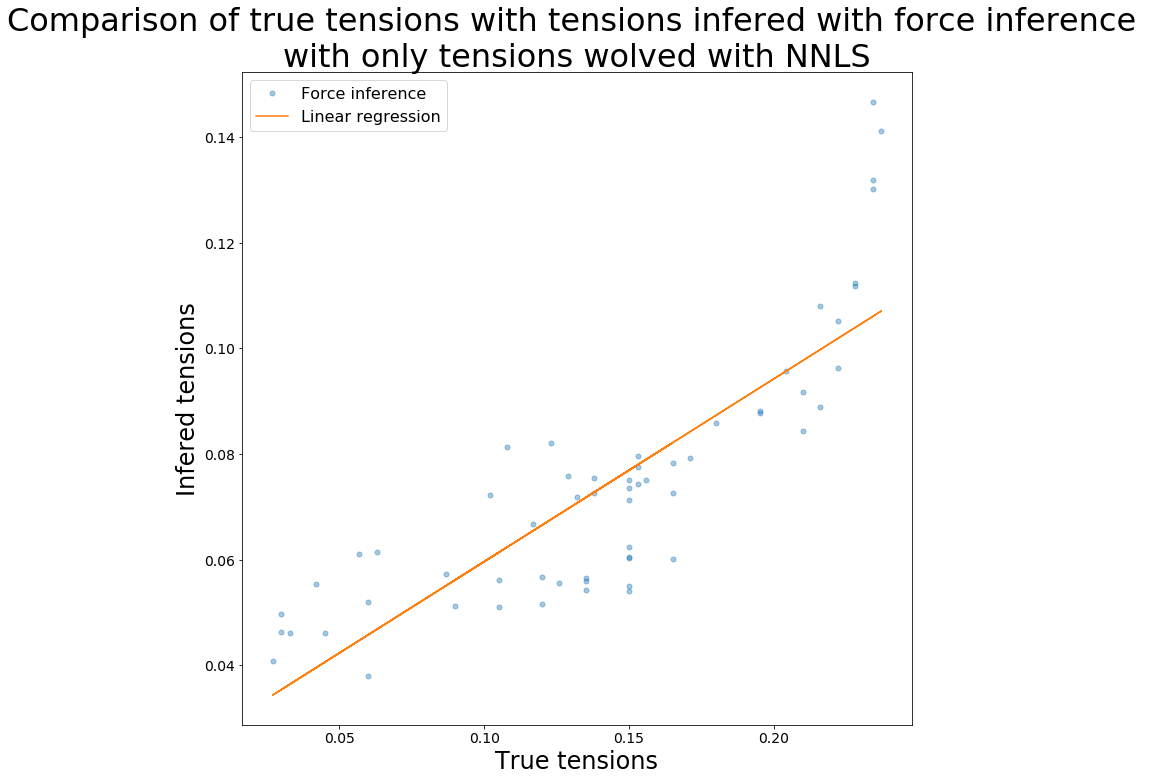

R value : 0.8365321021907081 
Standard error : 0.011537561905807401


In [14]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  mat_eq_cst[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [15]:
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
start_copy = time.time()
iprint_file = "../../assets/dist_at_each_f_ev/14_03_eq_t_per_cell_new_criteria.txt"
to_opt_organo = organo.copy()
init_point_area_and_tensions_opt = np.concatenate((prepare_tensions(to_opt_organo, mat_eq_cst[:3*organo.Nf]),
                                                   to_opt_organo.face_df.area + mat_eq_cst[3*organo.Nf:-1],
                                                   [to_opt_organo.settings['lumen_volume'] + mat_eq_cst[-1]]))
res_2_cst_areas_copy = adjust_parameters(to_opt_organo,
                                    init_point_area_and_tensions_opt,
                                    {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                    COPY_OR_SYM='copy',                                    
                                    **lm_opt)
end_copy = time.time()
print('Execution time: ', start_copy - end_copy)

6.054971657673226 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.2592647  0.29689547 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971665384794 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920612
 0.19325098 0.2592647  0.29689547 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971588058242 [0.18911462 0.17867685 0.15124629 0.10614239 0.04091472 0.0892061
 0.193251   0.25926472 0.29689548 0.22833924 0.16408473 0.23246162
 0.23297296 0.23223165 0.1022987  0.09304712 0.05940427 0.09127049
 0.1552007  0.17033227 0.07080629 0.11362497 0.13355902 0.13538521
 0.15736931 0.21877195 0.2599555  0.21180555 0.05249402 0.08243808
 0.03421327 0.05327605 0.17067201 0.18392518 0.25496248 0.13241506
 0.14647653 0.14558532 0.12568268 0.10519715 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971655394686 [0.18911462 0.17867685 0.15124629 0.1061424  0.04091475 0.08920611
 0.19325099 0.25926471 0.29689548 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940427 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421324 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.0549716688100705 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.25926471 0.29689548 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355904 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421324 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.054971658099426 [0.18911462 0.17867685 0.1512463  0.10614241 0.04091476 0.08920612
 0.19325098 0.25926469 0.29689546 0.22833925 0.16408479 0.23246164
 0.23297295 0.23223162 0.10229868 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080627 0.11362496 0.13355904 0.13538525
 0.15736935 0.21877194 0.25995547 0.21180553 0.05249402 0.08243807
 0.03421321 0.05327608 0.17067201 0.18392516 0.25496245 0.13241508
 0.14647656 0.14558535 0.12568269 0.10519717 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971653798624 [0.18911462 0.17867685 0.15124629 0.1061424  0.04091474 0.08920611
 0.19325099 0.25926471 0.29689548 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.09127049
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538523
 0.15736933 0.21877194 0.25995549 0.21180554 0.05249402 0.08243808
 0.03421324 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.054971671081239 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.2592647  0.29689547 0.22833925 0.16408477 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736934 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241508
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971663925725 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920612
 0.19325098 0.2592647  0.29689547 0.22833925 0.16408477 0.23246163
 0.23297295 0.23223163 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355904 0.13538524
 0.15736934 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241508
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971673953818 [0.18911462 0.17867685 0.15124629 0.1061424  0.04091474 0.08920611
 0.19325099 0.25926471 0.29689548 0.22833925 0.16408475 0.23246163
 0.23297296 0.23223164 0.10229869 0.09304712 0.05940428 0.09127049
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538523
 0.15736933 0.21877195 0.25995549 0.21180555 0.05249402 0.08243808
 0.03421325 0.05327606 0.17067202 0.18392517 0.25496247 0.13241507
 0.14647654 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

6.054971640823135 [0.18911462 0.17867685 0.1512463  0.10614241 0.04091475 0.08920612
 0.19325098 0.2592647  0.29689547 0.22833925 0.16408477 0.23246163
 0.23297295 0.23223163 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355904 0.13538524
 0.15736934 0.21877194 0.25995548 0.21180554 0.05249402 0.08243807
 0.03421323 0.05327607 0.17067201 0.18392516 0.25496246 0.13241508
 0.14647655 0.14558535 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971657673226 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.2592647  0.29689547 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971657673226 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.2592647  0.29689547 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971657673226 [0.18911462 0.17867685 0.1512463  0.1061424  0.04091475 0.08920611
 0.19325099 0.2592647  0.29689547 0.22833925 0.16408476 0.23246163
 0.23297295 0.23223164 0.10229869 0.09304712 0.05940428 0.0912705
 0.1552007  0.17033227 0.07080628 0.11362497 0.13355903 0.13538524
 0.15736933 0.21877194 0.25995548 0.21180554 0.05249402 0.08243808
 0.03421323 0.05327607 0.17067201 0.18392517 0.25496246 0.13241507
 0.14647655 0.14558534 0.12568269 0.10519716 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971616732799 [0.18911462 0.17867685 0.15124628 0.10614238 0.0409147  0.0892061
 0.193251   0.25926474 0.2968955  0.22833925 0.1640847  0.23246161
 0.23297296 0.23223167 0.10229871 0.09304712 0.05940427 0.09127048
 0.1552007  0.17033227 0.0708063  0.11362498 0.13355901 0.13538519
 0.1573693  0.21877195 0.25995552 0.21180556 0.05249403 0.08243809
 0.0342133  0.05327604 0.17067202 0.18392519 0.25496249 0.13241505
 0.14647652 0.14558531 0.12568268 0.10519715 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971086808212 [0.1891147  0.17867688 0.15124609 0.10614207 0.04091409 0.08920582
 0.19325128 0.25926518 0.29689588 0.22833915 0.16408375 0.23246137
 0.23297311 0.23223217 0.10229904 0.09304712 0.05940416 0.0912702
 0.1552007  0.17033223 0.07080656 0.11362515 0.13355873 0.13538459
 0.15736875 0.21877209 0.25995607 0.21180585 0.05249412 0.08243835
 0.03421426 0.05327572 0.17067214 0.18392555 0.25496295 0.13241468
 0.14647614 0.14558489 0.12568255 0.10519693 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.0549716780980845 [0.18911459 0.17867683 0.15124635 0.10614251 0.04091496 0.0892062
 0.19325089 0.25926455 0.29689534 0.22833929 0.16408509 0.23246171
 0.2329729  0.23223145 0.10229857 0.09304712 0.05940431 0.09127059
 0.1552007  0.17033228 0.07080618 0.11362491 0.13355912 0.13538543
 0.15736951 0.21877189 0.25995529 0.21180544 0.05249398 0.08243799
 0.0342129  0.05327618 0.17067197 0.18392504 0.2549623  0.1324152
 0.14647667 0.14558548 0.12568273 0.10519723 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

6.054971534968349 [0.18911464 0.17867686 0.15124625 0.10614233 0.0409146  0.08920605
 0.19325105 0.25926481 0.29689557 0.22833923 0.16408453 0.23246157
 0.23297299 0.23223176 0.10229877 0.09304712 0.05940425 0.09127043
 0.1552007  0.17033226 0.07080634 0.11362501 0.13355897 0.13538509
 0.1573692  0.21877198 0.25995561 0.21180561 0.05249404 0.08243814
 0.03421347 0.05327599 0.17067204 0.18392525 0.25496257 0.13241499
 0.14647646 0.14558524 0.12568266 0.10519711 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9532503364631826 [0.01134879 0.01540498 0.02504448 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503601067372 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101467 0.06302294
 0.0475166  0.0043713  0.04323225 0.05519822 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705214 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543763 0.0507135  0.08866613 0.04655834 0.05154635 0.10514416
 0.21793369 0.04070451 0.02694596 0.12293992 0.0348869  0.0329893
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9532503397131036 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503422070437 [0.01134879 0.01540498 0.02504448 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503417175402 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.953250341706895 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.953250338785768 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9532503371381196 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543763 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503307614253 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514416
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.953250342189845 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914995
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293048 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.9532503412231024 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503412231024 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503412231024 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070451 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532503357565096 [0.01134879 0.01540498 0.02504448 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363236
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.9532504136789965 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101467 0.06302294
 0.0475166  0.00437131 0.04323225 0.05519822 0.07512841 0.02202951
 0.06983775 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705214 0.03565293 0.00787082 0.08570832 0.00363236
 0.03543763 0.05071351 0.08866613 0.04655833 0.05154636 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293993 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347142 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.95325033868115 [0.01134879 0.01540498 0.02504449 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514416
 0.2179337  0.04070452 0.02694596 0.12293993 0.03488689 0.03298929
 0.0194051  0.02866127 0.01293049 0.01347141 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.9532503527800522 [0.01134879 0.01540498 0.02504448 0.09680699 0.06101466 0.06302294
 0.04751659 0.00437131 0.04323224 0.05519821 0.07512841 0.02202951
 0.06983774 0.017275   0.09186034 0.02394582 0.05021954 0.02914994
 0.04199159 0.04705213 0.03565293 0.00787082 0.08570832 0.00363235
 0.03543764 0.05071351 0.08866613 0.04655833 0.05154635 0.10514417
 0.2179337  0.04070452 0.02694596 0.12293992 0.0348869  0.03298929
 0.0194051  0.02866127 0.01293049 0.01347142 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.745562862621604 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257956 0.0416611  0.08160813 0.0241726  0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.7455626900901096 [0.01091159 0.01537019 0.02758442 0.07978316 0.04498314 0.06009103
 0.05658146 0.01958459 0.06166153 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897276 0.03882572 0.02764296 0.01460688 0.05229801 0.02800317
 0.01701519 0.03570673 0.07392388 0.03665249 0.04818727 0.11263288
 0.14504729 0.03257954 0.04166108 0.08160812 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.745562805156509 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229801 0.02800317
 0.01701519 0.03570673 0.07392389 0.03665249 0.04818727 0.11263288
 0.14504729 0.03257955 0.04166109 0.08160812 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.7455628589636394 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460689 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628575116147 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009104
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.0739239  0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628470813789 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628472611493 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310676 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.745562802813395 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498315 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229801 0.02800317
 0.01701519 0.03570673 0.07392389 0.03665249 0.04818727 0.11263288
 0.14504729 0.03257955 0.04166109 0.08160812 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.7455627955411663 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229801 0.02800317
 0.01701519 0.03570673 0.07392389 0.03665249 0.04818727 0.11263288
 0.14504729 0.03257955 0.04166109 0.08160812 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.745562885571256 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088769
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.0739239  0.0366525  0.04818728 0.11263289
 0.1450473  0.03257956 0.0416611  0.08160813 0.0241726  0.02508011
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628532669483 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628532669483 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455628532669483 [0.01091159 0.01537019 0.02758442 0.07978317 0.04498314 0.06009103
 0.05658146 0.0195846  0.06166154 0.07644178 0.06354374 0.03272833
 0.03917623 0.02896224 0.068627   0.01624156 0.03711045 0.02088768
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800317
 0.01701519 0.03570673 0.07392389 0.0366525  0.04818728 0.11263289
 0.14504729 0.03257955 0.0416611  0.08160813 0.02417261 0.0250801
 0.03330041 0.03022911 0.02403964 0.02310675 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455630886517883 [0.01091159 0.0153702  0.02758442 0.07978318 0.04498315 0.06009104
 0.05658147 0.01958461 0.06166154 0.07644178 0.06354374 0.03272832
 0.03917622 0.02896225 0.06862701 0.01624156 0.03711045 0.02088769
 0.03897277 0.03882572 0.02764296 0.01460688 0.05229802 0.02800318
 0.0170152  0.03570673 0.07392391 0.03665251 0.04818729 0.11263289
 0.14504731 0.03257957 0.04166111 0.08160814 0.0241726  0.02508011
 0.03330042 0.03022912 0.02403964 0.02310676 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.745563085252022 [0.01091159 0.01537019 0.02758442 0.07978318 0.04498315 0.06009104
 0.05658147 0.0195846  0.06166154 0.07644178 0.06354374 0.03272832
 0.03917622 0.02896225 0.06862701 0.01624156 0.03711045 0.02088769
 0.03897277 0.03882572 0.02764297 0.01460689 0.05229802 0.02800318
 0.0170152  0.03570672 0.07392391 0.03665251 0.04818729 0.11263289
 0.14504731 0.03257957 0.04166111 0.08160814 0.0241726  0.02508011
 0.03330042 0.03022912 0.02403964 0.02310676 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455637351979334 [0.01091159 0.0153702  0.02758443 0.0797832  0.04498317 0.06009105
 0.0565815  0.01958463 0.06166155 0.07644179 0.06354375 0.03272831
 0.03917622 0.02896226 0.06862703 0.01624156 0.03711046 0.0208877
 0.03897279 0.03882574 0.02764298 0.01460689 0.05229805 0.02800319
 0.0170152  0.03570673 0.07392395 0.03665254 0.04818733 0.11263291
 0.14504734 0.03257961 0.04166116 0.08160817 0.02417259 0.02508014
 0.03330044 0.03022914 0.02403965 0.02310677 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.7455633394811345 [0.01091159 0.0153702  0.02758443 0.07978319 0.04498316 0.06009105
 0.05658148 0.01958461 0.06166154 0.07644179 0.06354374 0.03272832
 0.03917622 0.02896226 0.06862702 0.01624156 0.03711046 0.02088769
 0.03897278 0.03882573 0.02764297 0.01460689 0.05229803 0.02800319
 0.0170152  0.03570672 0.07392392 0.03665252 0.04818731 0.1126329
 0.14504732 0.03257959 0.04166113 0.08160815 0.0241726  0.02508012
 0.03330043 0.03022913 0.02403965 0.02310676 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788483166503 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975511 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.347077085180748 [0.00740943 0.02817689 0.01988576 0.05077499 0.02958387 0.03616983
 0.03889466 0.01709306 0.04332657 0.07909872 0.04907163 0.02662568
 0.02203884 0.02057279 0.04768906 0.00924298 0.03130873 0.0233961
 0.02342485 0.03292891 0.02098329 0.01119974 0.04264642 0.01863736
 0.01589875 0.02520786 0.04982319 0.02772341 0.04873055 0.09575164
 0.09067846 0.03794812 0.0289869  0.05282247 0.01527294 0.03565567
 0.03975507 0.01800148 0.02106321 0.01357718 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3470788427417424 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203888 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.04264649 0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975511 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788779957419 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332672 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119976 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282256 0.015273   0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788936978941 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889475 0.01709307 0.04332672 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772347 0.04873065 0.09575171
 0.09067849 0.03794818 0.02898695 0.05282256 0.015273   0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3470788632337167 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282256 0.015273   0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788443910993 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909873 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.04264649 0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975511 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.347078948110823 [0.00740941 0.02817692 0.01988579 0.05077507 0.02958391 0.03616988
 0.03889475 0.01709307 0.04332672 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057285 0.04768913 0.00924299 0.03130878 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772347 0.04873066 0.09575171
 0.09067849 0.03794818 0.02898695 0.05282256 0.015273   0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470785695401806 [0.00740941 0.02817692 0.01988578 0.05077505 0.0295839  0.03616987
 0.03889473 0.01709307 0.04332669 0.07909873 0.04907161 0.0266258
 0.02203888 0.02057284 0.04768912 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098331 0.01119975 0.04264648 0.01863738
 0.01589877 0.02520792 0.04982324 0.02772346 0.04873064 0.09575169
 0.09067849 0.03794817 0.02898694 0.05282254 0.01527299 0.03565571
 0.03975511 0.0180015  0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.347078745782051 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616987
 0.03889474 0.01709307 0.04332671 0.07909873 0.04907161 0.02662581
 0.02203888 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.04264649 0.01863738
 0.01589878 0.02520793 0.04982325 0.02772346 0.04873064 0.0957517
 0.09067849 0.03794817 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975511 0.0180015  0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3470788587219957 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788587219957 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470788587219957 [0.00740941 0.02817692 0.01988579 0.05077506 0.0295839  0.03616988
 0.03889474 0.01709307 0.04332671 0.07909874 0.0490716  0.02662582
 0.02203889 0.02057284 0.04768913 0.00924299 0.03130877 0.02339612
 0.02342486 0.03292894 0.02098332 0.01119975 0.0426465  0.01863738
 0.01589878 0.02520794 0.04982325 0.02772346 0.04873065 0.0957517
 0.09067849 0.03794818 0.02898694 0.05282255 0.01527299 0.03565572
 0.03975512 0.01800151 0.02106324 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.3470783811376088 [0.00740941 0.02817692 0.01988578 0.05077504 0.02958389 0.03616986
 0.03889472 0.01709307 0.04332668 0.07909873 0.04907161 0.02662578
 0.02203887 0.02057283 0.04768911 0.00924299 0.03130876 0.02339611
 0.02342486 0.03292893 0.02098331 0.01119974 0.04264647 0.01863738
 0.01589877 0.02520792 0.04982324 0.02772345 0.04873063 0.09575169
 0.09067849 0.03794816 0.02898693 0.05282253 0.01527298 0.03565571
 0.0397551  0.0180015  0.02106323 0.01357719 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3470777827676934 [0.00740942 0.0281769  0.01988577 0.05077502 0.02958388 0.03616985
 0.03889469 0.01709306 0.04332663 0.07909873 0.04907162 0.02662574
 0.02203886 0.02057281 0.04768909 0.00924298 0.03130874 0.02339611
 0.02342485 0.03292892 0.0209833  0.01119974 0.04264645 0.01863737
 0.01589876 0.02520789 0.04982322 0.02772343 0.04873059 0.09575166
 0.09067848 0.03794814 0.02898692 0.0528225  0.01527296 0.03565569
 0.03975509 0.01800149 0.02106322 0.01357718 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.3470800451865932 [0.0074094  0.02817694 0.0198858  0.05077511 0.02958392 0.0361699
 0.0388948  0.01709307 0.04332681 0.07909874 0.04907158 0.02662591
 0.02203892 0.02057287 0.04768918 0.00924299 0.0313088  0.02339614
 0.02342487 0.03292897 0.02098334 0.01119977 0.04264655 0.0186374
 0.01589879 0.02520799 0.04982329 0.0277235  0.04873071 0.09575175
 0.09067851 0.03794822 0.02898698 0.05282261 0.01527303 0.03565575
 0.03975515 0.01800153 0.02106326 0.0135772  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.3470782845170253 [0.00740942 0.02817691 0.01988578 0.05077504 0.02958389 0.03616986
 0.03889472 0.01709307 0.04332667 0.07909873 0.04907161 0.02662577
 0.02203887 0.02057283 0.04768911 0.00924298 0.03130876 0.02339611
 0.02342485 0.03292893 0.02098331 0.01119975 0.04264647 0.01863738
 0.01589877 0.02520791 0.04982323 0.02772345 0.04873062 0.09575168
 0.09067848 0.03794816 0.02898693 0.05282253 0.01527298 0.0356557
 0.0397551  0.0180015  0.02106324 0.01357718 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733842500854666 [0.00617161 0.02644761 0.01632397 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842563686637 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.0080614  0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303526 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842441041836 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416402 0.03358812
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842485229125 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842510385909 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.273384245077604 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733842476953896 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842554118664 [0.00617161 0.02644761 0.01632397 0.04469971 0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721575 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842482156708 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721575 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.273384247657391 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416402 0.03358812
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733842599964955 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373056 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733842050011788 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.0080614  0.0446271  0.07711414 0.0524762  0.02804738
 0.01974418 0.02238253 0.04343402 0.00721575 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670285 0.026789   0.04032689 0.03459076 0.05303526 0.0840373
 0.08129994 0.04270493 0.03396626 0.04912793 0.01416403 0.03358812
 0.03151495 0.01889578 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733842493283758 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149994
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733851771901556 [0.00617155 0.02645    0.01631632 0.0447025  0.02852989 0.03238739
 0.0337303  0.00806163 0.04462693 0.07711407 0.05247618 0.02804728
 0.01974409 0.02238251 0.04343428 0.00721595 0.02902324 0.02150014
 0.02147759 0.0313052  0.02052063 0.01134668 0.03586766 0.01842359
 0.01669877 0.02678878 0.04032697 0.03459082 0.05303544 0.08403745
 0.08130007 0.04270505 0.03396634 0.04912802 0.01416392 0.03358822
 0.03151502 0.01889591 0.02051999 0.0112688  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733752730459147 [0.00617177 0.02644774 0.0163238  0.04469961 0.02852999 0.0323826
 0.03372594 0.00806293 0.04462729 0.07711389 0.05247629 0.02804696
 0.01974386 0.02238249 0.04343411 0.00721584 0.029023   0.0215001
 0.02147752 0.03130503 0.02052036 0.01134764 0.03586557 0.01841982
 0.01670096 0.02678521 0.04032937 0.03459127 0.05303496 0.08403807
 0.08130049 0.04270543 0.03396644 0.04912772 0.01416405 0.03358803
 0.03151478 0.01889576 0.02051981 0.01126878 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.2733826548907063 [0.00616956 0.0264471  0.01632408 0.04470037 0.02852929 0.03238783
 0.03373231 0.00806004 0.04461621 0.07710743 0.05248186 0.02804438
 0.01974256 0.02238455 0.04343464 0.00721419 0.02902058 0.02150019
 0.02147666 0.03130437 0.02051955 0.01134847 0.03586529 0.01841945
 0.01670154 0.02679167 0.04032388 0.0345889  0.05303573 0.08404486
 0.08130835 0.0427135  0.03396801 0.04912608 0.01416779 0.03358643
 0.03151179 0.01889496 0.02051936 0.01126885 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2734435020773365 [0.006172   0.0264483  0.01632445 0.04470096 0.02852962 0.03238798
 0.03373122 0.00806206 0.04462865 0.07711587 0.05247502 0.02805943
 0.01975678 0.02238461 0.04343547 0.00721645 0.02902477 0.02150033
 0.02147795 0.03130583 0.02052145 0.01134783 0.035867   0.01842027
 0.01670406 0.02678946 0.04032876 0.03459105 0.05303469 0.08403461
 0.08129828 0.04271186 0.03397167 0.04912814 0.01416399 0.03358932
 0.03151653 0.01889671 0.02052095 0.01126915 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733723315153902 [0.00617185 0.02644782 0.0163239  0.04469987 0.02852936 0.03238755
 0.03373033 0.00806163 0.04462691 0.0771141  0.05247618 0.02804746
 0.01974366 0.02237995 0.04343064 0.0072152  0.0290212  0.0215
 0.02147757 0.03130513 0.02052054 0.01134763 0.03586578 0.01841968
 0.01670298 0.02678897 0.04032703 0.03459081 0.05303529 0.08403716
 0.08129982 0.04270476 0.03396611 0.04912438 0.01416277 0.0335917
 0.03151198 0.01889579 0.02052    0.01126883 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

1.2733865468338625 [0.00617168 0.02644788 0.01632389 0.04469992 0.02852943 0.0323876
 0.03373034 0.00806164 0.04462709 0.07711414 0.05247614 0.02804739
 0.01974415 0.02238248 0.04343429 0.00721597 0.02902593 0.02150324
 0.02146984 0.03130478 0.02052056 0.01134768 0.03586584 0.01841969
 0.016703   0.02678902 0.04032708 0.03459083 0.05303531 0.08403732
 0.08129999 0.04270497 0.03396636 0.0491281  0.01416389 0.03358807
 0.03151162 0.01889988 0.02051816 0.01127134 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273396086499353 [0.00616766 0.02644688 0.01632532 0.0447001  0.02852936 0.03238755
 0.03373043 0.00806161 0.04462712 0.07711414 0.05247617 0.02804748
 0.01974423 0.02238252 0.04343427 0.00721595 0.02902336 0.02150013
 0.02147766 0.0313071  0.02052315 0.01135786 0.03586472 0.0184195
 0.01670299 0.02678903 0.04032711 0.03459082 0.05303526 0.08403716
 0.08129983 0.04270486 0.03396629 0.04912814 0.01416389 0.03358829
 0.03151513 0.01889591 0.02051986 0.01126723 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.2733866425552902 [0.00617175 0.02644789 0.01632278 0.04470004 0.02852646 0.03238906
 0.03373017 0.00806157 0.04462687 0.07711405 0.05247621 0.02804724
 0.01974409 0.02238252 0.04343418 0.00721586 0.02902318 0.02150006
 0.0214775  0.03130505 0.02052047 0.01134756 0.03586533 0.01843122
 0.0166968  0.02678745 0.04032672 0.03459079 0.05303541 0.08403741
 0.08130001 0.04270503 0.03396628 0.04912794 0.01416396 0.03358815
 0.03151494 0.01889585 0.02051996 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733987862316827 [0.00617175 0.02644784 0.01632405 0.04470006 0.02852939 0.03238885
 0.03372963 0.00805721 0.04462929 0.07711386 0.05247652 0.0280478
 0.01974453 0.02238262 0.04343438 0.00721595 0.02902356 0.0215001
 0.02147758 0.0313052  0.02052066 0.01134773 0.03586599 0.01841983
 0.01670312 0.02679061 0.04032757 0.03460107 0.05303332 0.08403711
 0.08129941 0.0427048  0.03396624 0.04912841 0.01416396 0.03358842
 0.03151531 0.01889602 0.02052014 0.01126889 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.2734340389339125 [0.00616893 0.0264476  0.01632502 0.04470231 0.02852966 0.03238867
 0.03373438 0.00806077 0.04462952 0.07711511 0.0524759  0.02804649
 0.01974413 0.02238603 0.04343648 0.00721418 0.02902179 0.02150059
 0.02147689 0.0313052  0.02052018 0.01134926 0.03586661 0.01842024
 0.01670234 0.02679342 0.04032529 0.03459189 0.05304553 0.08404171
 0.08130308 0.04271494 0.03396806 0.04912776 0.01416938 0.03358712
 0.03151234 0.01889549 0.02052039 0.01126936 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.273404304252074 [0.00617167 0.02644774 0.01632399 0.0446999  0.02852931 0.03238748
 0.03373061 0.0080615  0.04462727 0.07711449 0.05247581 0.02804887
 0.01975205 0.02237679 0.04343647 0.00721624 0.02902325 0.02150006
 0.0214775  0.03130508 0.02052049 0.01134772 0.0358658  0.01841972
 0.01670294 0.02678912 0.04032703 0.03459082 0.05303548 0.08403735
 0.08130015 0.0427036  0.03397198 0.04913289 0.01416569 0.03358774
 0.03151498 0.01889587 0.02051998 0.01126885 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733955014601173 [0.00617175 0.02644776 0.01632389 0.04469983 0.02852933 0.0323875
 0.0337304  0.00806152 0.04462701 0.07711411 0.05247614 0.02804724
 0.01974401 0.02238216 0.04343526 0.00721587 0.02902766 0.02150026
 0.02147748 0.03130506 0.02052048 0.01134766 0.03586573 0.01841966
 0.01670291 0.02678905 0.04032692 0.0345908  0.05303546 0.08403765
 0.08130027 0.04270516 0.03396636 0.04912754 0.01416444 0.03359273
 0.03151369 0.0188959  0.02052    0.01126884 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733816799312123 [0.00617297 0.02644769 0.01632392 0.04469979 0.02852931 0.03238748
 0.03373038 0.00806154 0.04462697 0.0771141  0.05247619 0.0280473
 0.01974409 0.02238249 0.04343415 0.00721588 0.0290235  0.02150182
 0.02147246 0.03130426 0.02051921 0.01134781 0.03586568 0.01841966
 0.01670289 0.02678899 0.04032692 0.03459079 0.05303534 0.08403737
 0.08130001 0.04270499 0.03396631 0.04912794 0.01416395 0.03358814
 0.03151474 0.01889447 0.02051027 0.01127994 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273406087078839 [0.00616313 0.02646408 0.01631748 0.04469981 0.02852863 0.03238689
 0.03373115 0.00806109 0.04462753 0.0771143  0.05247626 0.0280479
 0.01974471 0.0223827  0.04343379 0.00721543 0.02902342 0.02149959
 0.02147688 0.03130547 0.02052651 0.01135361 0.03587438 0.01842029
 0.01670304 0.02678908 0.04032707 0.03459067 0.05303481 0.08403644
 0.08129916 0.04270436 0.03396594 0.04912816 0.01416417 0.03358816
 0.03151507 0.01889575 0.02052012 0.01126908 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.273384121144374 [0.00617113 0.02644712 0.01632439 0.04470077 0.02854769 0.0323811
 0.03373114 0.00806097 0.04462756 0.07711433 0.05247625 0.02804784
 0.01974462 0.02238264 0.04343366 0.0072154  0.02902334 0.02149956
 0.02147703 0.03130457 0.02052017 0.01134792 0.03586597 0.01841451
 0.01668959 0.02679633 0.04032738 0.03459061 0.05303477 0.08403656
 0.08129928 0.04270441 0.03396595 0.04912799 0.01416423 0.03358805
 0.03151497 0.01889564 0.02051982 0.01126886 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.2733856947179387 [0.00617128 0.02644709 0.01632404 0.04469915 0.02852845 0.03238626
 0.03373001 0.00808027 0.04461996 0.07711594 0.05247462 0.02804762
 0.01974431 0.02238232 0.04343339 0.00721547 0.0290232  0.02149943
 0.02147695 0.0313044  0.02052022 0.0113477  0.03586532 0.01841961
 0.01670289 0.02678761 0.04033424 0.03457924 0.05304207 0.08403498
 0.08129965 0.04270352 0.03396585 0.04912778 0.01416371 0.03358796
 0.03151492 0.01889565 0.02051981 0.01126879 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2734223379327179 [0.0061702  0.02644758 0.01632421 0.04470095 0.02852949 0.03238777
 0.03373295 0.00806046 0.04463472 0.07711381 0.05247229 0.02805373
 0.01974347 0.02238383 0.04343497 0.00721569 0.02902352 0.02150011
 0.02147707 0.03130514 0.02051998 0.01134851 0.03586629 0.01841974
 0.01670254 0.0267917  0.04032624 0.03459118 0.05303603 0.08405572
 0.0812936  0.04270576 0.0339713  0.04912898 0.01416744 0.03358719
 0.03151384 0.01889552 0.02051996 0.01126886 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733381185024446 [0.00617095 0.02644684 0.01632391 0.04469871 0.02852849 0.03238647
 0.03373079 0.00806064 0.04462693 0.07711369 0.05247678 0.02804499
 0.01975214 0.02237369 0.04342681 0.00721403 0.02902269 0.02149938
 0.02147677 0.0313041  0.02051958 0.01134778 0.03586481 0.0184194
 0.01670208 0.02678868 0.04032593 0.03459053 0.053035   0.08403792
 0.08130025 0.0427073  0.03397032 0.04910855 0.01415456 0.03358916
 0.03151443 0.01889515 0.0205192  0.01126867 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733720551328997 [0.00617081 0.02644683 0.01632399 0.04469888 0.02852847 0.03238652
 0.03373096 0.00806064 0.04462684 0.07711407 0.05247631 0.02804683
 0.01974391 0.02238278 0.04343314 0.00721458 0.0290299  0.02150145
 0.02147706 0.03130412 0.02051963 0.01134786 0.03586489 0.01841945
 0.01670214 0.02678891 0.04032593 0.03459055 0.05303551 0.08403822
 0.08130068 0.04270542 0.03396616 0.04912724 0.01416404 0.03359389
 0.03149578 0.0189001  0.02051897 0.01126861 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.273410229445272 [0.00616763 0.02644781 0.01632414 0.04469961 0.02852869 0.03238691
 0.03373117 0.00806111 0.04462762 0.07711434 0.05247625 0.02804799
 0.01974478 0.0223827  0.04343382 0.00721546 0.0290234  0.02149986
 0.02146855 0.03132188 0.0205305  0.01134779 0.03586585 0.0184198
 0.01670299 0.02678908 0.04032715 0.03459068 0.05303472 0.08403629
 0.08129904 0.04270427 0.03396592 0.04912824 0.01416414 0.03358821
 0.03151522 0.01889622 0.02053017 0.01127025 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273384247320625 [0.00617161 0.02644761 0.01632396 0.0446997  0.02852916 0.03238732
 0.03373055 0.00806141 0.0446271  0.07711414 0.0524762  0.02804739
 0.01974419 0.02238253 0.04343403 0.00721576 0.02902321 0.02149995
 0.0214774  0.03130493 0.02052038 0.01134771 0.03586565 0.01841967
 0.01670286 0.026789   0.0403269  0.03459076 0.05303525 0.08403729
 0.08129993 0.04270492 0.03396625 0.04912794 0.01416403 0.03358813
 0.03151496 0.01889579 0.02051989 0.01126882 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733820222995529 [0.00617004 0.0264474  0.01632376 0.0446996  0.02852926 0.03238741
 0.0337304  0.00806144 0.04462692 0.07711406 0.05247618 0.02804713
 0.01974396 0.0223825  0.04343404 0.00721579 0.02902306 0.02150003
 0.02147735 0.03130514 0.0205215  0.01134544 0.03586575 0.0184197
 0.01670277 0.026789   0.04032673 0.03459078 0.05303553 0.08403781
 0.08130039 0.04270525 0.03396637 0.04912777 0.01416406 0.03358803
 0.03151481 0.01889574 0.02051994 0.01126915 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733858585100581 [0.00617166 0.02644758 0.01632398 0.04469996 0.02852824 0.03238764
 0.03373054 0.00806141 0.04462697 0.07711408 0.05247618 0.02804721
 0.01974402 0.02238251 0.04343404 0.00721578 0.02902311 0.02150001
 0.02147744 0.03130496 0.02052035 0.01134774 0.03586584 0.01841813
 0.01670516 0.02678947 0.0403269  0.03459078 0.05303547 0.08403769
 0.08130029 0.04270517 0.03396636 0.04912783 0.01416405 0.03358807
 0.03151486 0.01889576 0.02051984 0.0112688  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0. 

1.2733811697610755 [0.0061716  0.02644758 0.01632384 0.04469958 0.02852919 0.03238743
 0.03373033 0.00805944 0.04462613 0.07711396 0.05247616 0.02804671
 0.01974368 0.0223825  0.04343393 0.00721568 0.0290228  0.0215
 0.02147738 0.03130485 0.02052022 0.01134766 0.03586543 0.01841953
 0.01670264 0.02678868 0.04032802 0.0345903  0.05303639 0.08403837
 0.08130088 0.04270563 0.03396647 0.04912749 0.01416415 0.03358787
 0.03151456 0.01889564 0.0205197  0.01126876 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

1.273388566310514 [0.00616971 0.02644648 0.01632311 0.0446985  0.02852909 0.03238694
 0.03373099 0.00805933 0.04462717 0.07711377 0.05247539 0.02804351
 0.01974083 0.02238349 0.04343278 0.00721408 0.02901929 0.02149981
 0.0214763  0.03130347 0.02051859 0.01134786 0.03586402 0.01841858
 0.01670032 0.0267905  0.04032282 0.0345914  0.05304147 0.08405319
 0.08131456 0.04271333 0.0339693  0.04912447 0.01416733 0.03358538
 0.03151088 0.01889421 0.02051806 0.01126825 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733929799392687 [0.00617185 0.02644786 0.01632407 0.0447001  0.02852929 0.03238755
 0.03373054 0.00806171 0.0446273  0.07711418 0.05247621 0.0280473
 0.01974677 0.02238132 0.04343425 0.007216   0.02902376 0.02150008
 0.0214776  0.03130524 0.02052079 0.01134768 0.03586607 0.01841983
 0.01670334 0.02678906 0.04032753 0.03459081 0.05303488 0.08403636
 0.08129913 0.04270498 0.03396707 0.04912961 0.01416339 0.03358865
 0.03151549 0.01889613 0.02052029 0.01126891 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.273398258876317 [0.00617191 0.02644797 0.0163242  0.04470032 0.02852933 0.03238766
 0.03373069 0.00806184 0.04462761 0.0771143  0.05247622 0.02804841
 0.01974495 0.02238264 0.04343476 0.00721608 0.02902542 0.02150032
 0.02147772 0.03130539 0.02052101 0.01134772 0.03586633 0.01841998
 0.01670358 0.02678909 0.04032795 0.0345909  0.05303457 0.08403543
 0.08129831 0.0427038  0.033966   0.04912909 0.01416341 0.03359005
 0.03151749 0.01889637 0.02052047 0.01126898 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

1.2733832809493966 [0.00617192 0.02644761 0.01632388 0.04469966 0.02852925 0.03238738
 0.03373041 0.00806141 0.04462691 0.07711406 0.05247617 0.02804709
 0.01974393 0.0223825  0.04343401 0.00721576 0.02902294 0.02150012
 0.02147542 0.03130477 0.02052056 0.01134755 0.03586555 0.0184196
 0.01670273 0.02678899 0.04032669 0.03459078 0.05303556 0.08403791
 0.08130048 0.0427053  0.0339664  0.04912773 0.01416408 0.03358802
 0.03151487 0.01889611 0.02052217 0.01126699 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

Distance from th organo to exp organo : 1.2734747257376748
Distance from th tensions to exp tensions : 0.6336461461517535


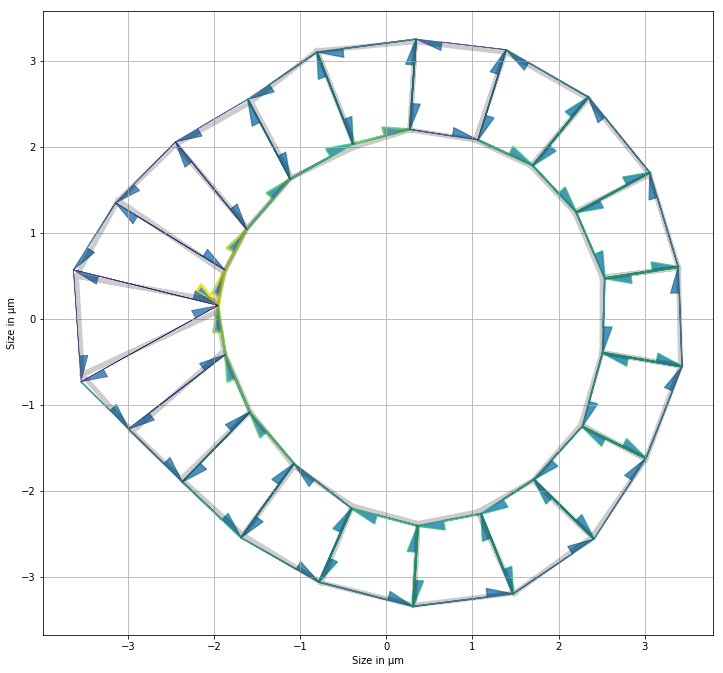

In [16]:
opt_mat_2_cst_organo = to_opt_organo.copy()
opt_mat_2_cst_organo.edge_df.line_tension = prepare_tensions(opt_mat_2_cst_organo, res_2_cst_areas_copy.x[:organo.Nf*3])
opt_mat_2_cst_organo.face_df.prefered_area = res_2_cst_areas_copy.x[4*organo.Nf:5*organo.Nf]
opt_mat_2_cst_organo.settings['prefered_lumen_vol'] = opt_mat_2_cst_organo.settings['lumen_volume'] + res_2_cst_areas_copy.x[-1]
Solver.find_energy_min(opt_mat_2_cst_organo, geom, model)
print_tensions(opt_mat_2_cst_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_mat_2_cst_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*organo.Nf] -
                                opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf]))))

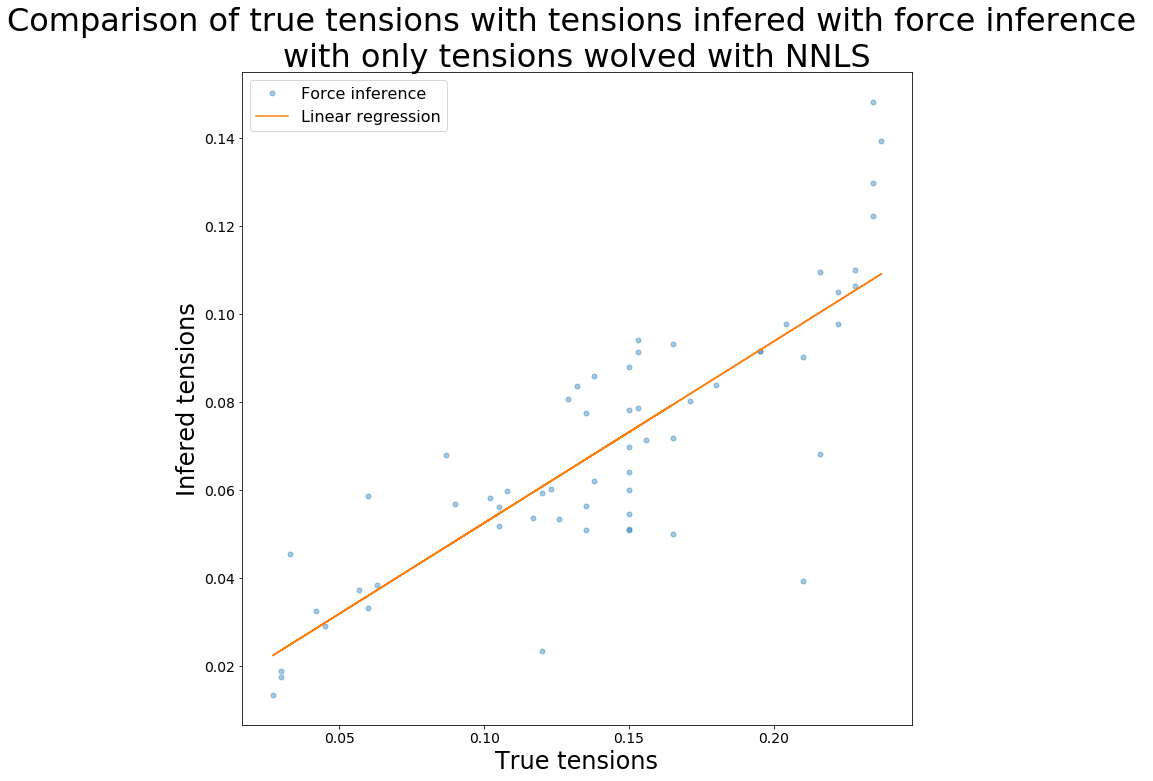

R value : 0.8280845249402147 
Standard error : 0.01420559703304353


In [17]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_mat_2_cst_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))